In [1]:
from fastmcp import Client

from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json


In [2]:
import os

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    api_key = input("Please enter your OpenAI API key: ").strip()
    os.environ["OPENAI_API_KEY"] = api_key
    if not api_key:
        raise ValueError("API key is required.")

In [6]:
client = Client("http://localhost:8001/mcp")

async with client:
    tools = await client.list_tools()



In [7]:
tools

[Tool(name='get_formatted_item_context', title=None, description='Get the top k context, each representing an inventory item for a given query.\n\nArgs:\n    query: The query to get the top k context for\n    top_k: The number of context chunks to retrieve, works best with 5 or more\n\nReturns:\n    A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.', inputSchema={'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta={'_fastmcp': {'tags': []}})]

In [8]:

async with client:
    # List available resources
    result = await client.call_tool("get_formatted_item_context", {"query": "earphones", "top_k": 5})

In [9]:
result

CallToolResult(content=[TextContent(type='text', text="B09NLTDHQ6: Active Noise Cancelling Wireless Earbuds, Bluetooth in-Ear Headphones Built-in 4 Mic ENC Call, Deep Bass Ear Buds,IPX6 Waterproof Stereo Earphones for iPhone,Samsung,Laptop (Blue) ♪【ANC Noise Cancelling&Game Mode】: These premium noise-canceling earbuds adopts professional audio active noise canceling technology, and the binaural microphone blocks environmental noise and enhances the voice experience. M48 wireless earbuds are built to provide the exceptional mobile gaming audio experience with an ultra-low 45ms latency.Taps 5 times to enter game mode,through quick sound effect and ideal gaming audio you never miss any game sound effects. ♪【HiFi Stereo Sound & Superior Clear Call 】: Heaphones equipped with a high-sensitivity diaphragm and dual 13mm drivers to restore audio authenticity and voice dynamics, crystal clarity and deep resonance bass characteristics enable you to enjoy immersive sound quality. Call noise cancel

In [10]:
def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params


In [10]:
parse_docstring_params(tools[0].description)

{'query': 'The query to get the top k context for',
 'top_k': 'The number of context chunks to retrieve, works best with 5 or more'}

In [11]:
async def get_tool_descriptions_from_mcp_servers(mcp_servers: list[str]) -> list[dict]:

    tool_descriptions = []

    for server in mcp_servers:

        client = Client(server)

        async with client:

            tools = await client.list_tools()

            for tool in tools:
                
                result = {
                    "name": "",
                    "description": "",
                    "parameters": {"type": "object", "properties": {}},
                    "required": [],
                    "returns": {"type": "string", "description": ""},
                    "server": server
                }

                result["name"] = tool.name
                result["required"] = tool.inputSchema.get("required", [])

                ## Get Description

                description = tool.description.split("\n\n")[0]
                result["description"] = description


                ## Get Returns

                returns = tool.description.split("Returns:")[1].strip()
                result["returns"]["description"] = returns

                ## Get parameters

                property_descriptions = parse_docstring_params(tool.description)
                properties = tool.inputSchema.get("properties", {})
                for key, value in properties.items():
                    properties[key]["description"] = property_descriptions.get(key, "")

                result["parameters"]["properties"] = properties

                tool_descriptions.append(result)

    return tool_descriptions

In [12]:
mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]


In [13]:
tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)


In [14]:
tool_descriptions


[{'name': 'get_formatted_item_context',
  'description': 'Get the top k context, each representing an inventory item for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'string',
   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_formatted_review_context',
  'description': 'Get the top k reviews matching a query for a list of prefiltered items.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the t

In [32]:
class ToolCall(BaseModel):
    name: str
    arguments: dict
    server: str

class RAGUsedContext(BaseModel):
    id: int
    description: str

class ProductQAAgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    iteration: int = Field(default=0)
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: List[RAGUsedContext] = Field(default_factory=list)
    user_intent: str = ""

### The ProductQA Agent Node

In [33]:
@traceable(
    name="product_qa_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def product_qa_agent_node(state: State) -> dict:

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specifically provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
- You need to answer the question based on the retrieved context using the available tools only.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
- As a final output you need to provide:

* The answer to the question based on the retrieved context.
* The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Short description of the item based on the retrieved context.

- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function name and arguments.
- If you have all the information needed to provide a complete answer, set final_answer to True.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=ProductQAAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieved_context_ids": response.retrieved_context_ids
   }

### User Intent Router Node

In [23]:
class IntentRouterAgentResponse(BaseModel):
    user_intent: str
    answer: str

In [34]:
@traceable(
    name="intent_router_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def intent_router_agent_node(state: State) -> dict:

   prompt_template =  """You are a part of a shopping assistant that routes user queries to the appropriate agents.

You will be given a conversation history, your task is to classify the intent of the user's latest query and output an appropriate classification.

The possible intents are:

- product_qa: The user is asking a question about a product. This can be a question about available products, their specifications, user reviews etc.
- other: The user's latest query is not clear or not related to the shopping assistant.

Additional instructions:

- Write the intent classification to the user_intent field.
- If the classification is 'other', you should output the answer to the user's query trying to clarify the user's intent.
- If the classification is 'product_qa', you should only output the intent classification and no other text.
"""

   template = Template(prompt_template)
   
   prompt = template.render()

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=IntentRouterAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.user_intent == "product_qa":

      ai_message = []
   else:
      ai_message = [AIMessage(
         content=response.answer,
      )]

   return {
      "messages": ai_message,
      "answer": response.answer,
      "user_intent": response.user_intent,
   }

### The Tool Use Router ###

In [18]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

### User Intent Router

In [25]:
def user_intent_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.user_intent == "product_qa":
        return "product_qa_agent"
    if state.user_intent == "shopping_cart":
        return "shopping_cart_agent"
    else:
        return "end"

### Custom tool node function that supports running tools exposed by MCP servers

In [20]:
async def mcp_tool_node(state: State) -> str:

    tool_messages = []

    for i, tc in enumerate(state.tool_calls):

        client = Client(tc.server)

        async with client:

            result = await client.call_tool(tc.name, tc.arguments)

            tool_message = ToolMessage(
                content=result,
                tool_call_id=f"call_{i}"
            )

            tool_messages.append(tool_message)

    return {
        "messages": tool_messages
    }

In [16]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

### LangGraph Graph implementation with MCP support

In [29]:
workflow = StateGraph(State)

mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]

tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)

workflow.add_edge(START, "intent_router_agent_node")

workflow.add_node("intent_router_agent_node", intent_router_agent_node)
workflow.add_node("product_qa_agent_node", product_qa_agent_node)
workflow.add_node("mcp_tool_node", mcp_tool_node)

workflow.add_conditional_edges(
    "intent_router_agent_node",
    user_intent_router,
    {
        "product_qa_agent": "product_qa_agent_node",
        "end": END
    }
)

workflow.add_conditional_edges(
    "product_qa_agent_node",
    tool_router,
    {
        "tools": "mcp_tool_node",
        "end": END
    }
)

workflow.add_edge("mcp_tool_node", "product_qa_agent_node")

graph = workflow.compile()

ValueError: Channel 'retrieved_context_ids' already exists with a different type

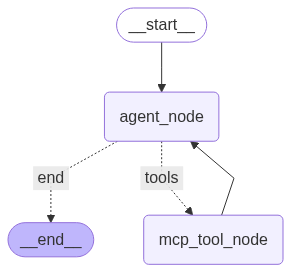

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
initial_state = {
    "messages": [{"role": "user", "content": "Can i get some earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions
}
result = await graph.ainvoke(initial_state)



ValidationError: 3 validation errors for State
tool_calls.0
  Input should be a valid dictionary or instance of ToolCall [type=model_type, input_value=ToolCall(name='get_format...p://localhost:8001/mcp'), input_type=ToolCall]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
tool_calls.1
  Input should be a valid dictionary or instance of ToolCall [type=model_type, input_value=ToolCall(name='get_format...p://localhost:8001/mcp'), input_type=ToolCall]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
tool_calls.2
  Input should be a valid dictionary or instance of ToolCall [type=model_type, input_value=ToolCall(name='get_format...p://localhost:8001/mcp'), input_type=ToolCall]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type